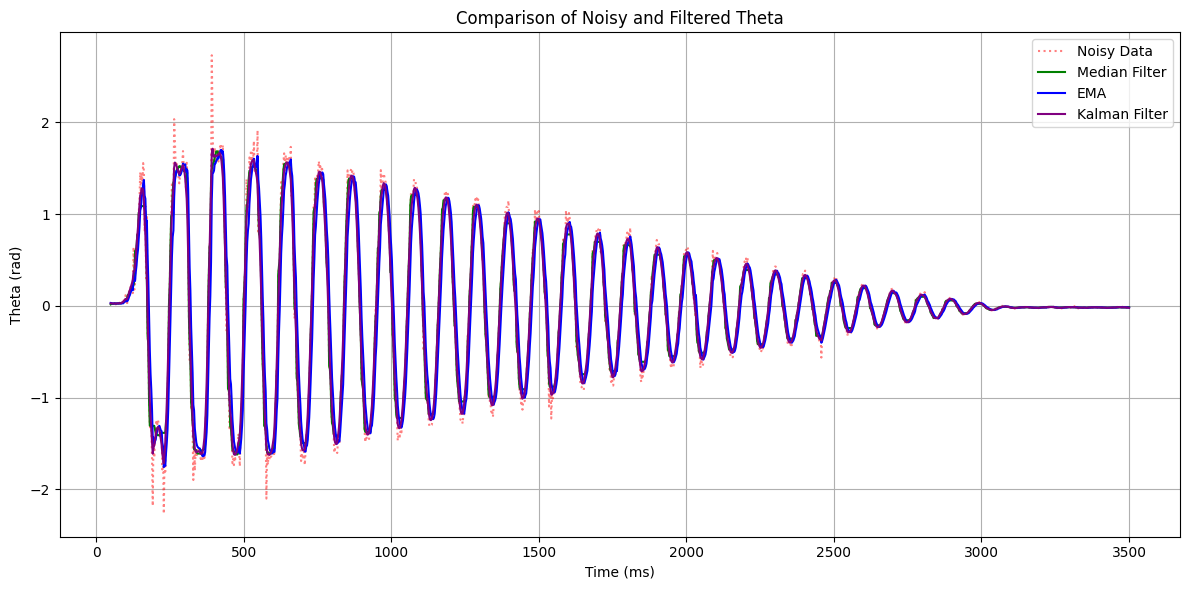

MSE - Median: 0.010474
MSE - EMA: 0.064617
MSE - Kalman: 0.010085


In [1]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Step 1: Load your data
df = pd.read_csv("datasets/other/updated_data.csv")
df['dt'] = df['time'].diff() / 1000.0
df = df.dropna().reset_index(drop=True)

# Step 2: Convert theta to radians
df['theta_rad'] = (df['theta'] / 2048.0) * np.pi

# Step 3: Apply filters
df['theta_med'] = medfilt(df['theta_rad'], kernel_size=15)
df['theta_ema'] = df['theta_rad'].ewm(alpha=0.3, adjust=False).mean()

# Step 4: Advanced Kalman Filter (position + velocity)
dt_mean = df['dt'].mean()

transition_matrix = [[1, dt_mean],
                     [0, 1]]
observation_matrix = [[1, 0]]

kf_advanced = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=[df['theta_rad'].iloc[0], 0],
    transition_covariance=np.diag([3e-3, 3e-3]),  # Q matrix
    observation_covariance=np.array([[0.01]])      # R matrix
)

filtered_state_means, _ = kf_advanced.smooth(df['theta_rad'].values)
df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]


# Step 5: Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['theta_rad'], label='Noisy Data', color='red', linestyle='dotted', alpha=0.5)
plt.plot(df['time'], df['theta_med'], label='Median Filter', color='green')
plt.plot(df['time'], df['theta_ema'], label='EMA', color='blue')
plt.plot(df['time'], df['theta_kalman'], label='Kalman Filter', color='purple')
plt.xlabel("Time (ms)")
plt.ylabel("Theta (rad)")
plt.title("Comparison of Noisy and Filtered Theta")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Step 6: Metrics
mse_median = mean_squared_error(df['theta_rad'], df['theta_med'])
mse_ema = mean_squared_error(df['theta_rad'], df['theta_ema'])
mse_kalman = mean_squared_error(df['theta_rad'], df['theta_kalman'])

print(f"MSE - Median: {mse_median:.6f}")
print(f"MSE - EMA: {mse_ema:.6f}")
print(f"MSE - Kalman: {mse_kalman:.6f}")

In [2]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# Load raw data
df = pd.read_csv("updated_data.csv")
df['dt'] = df['time'].diff() / 1000.0
df = df.dropna().reset_index(drop=True)
df['theta_rad'] = (df['theta'] / 2048.0) * np.pi

# Kalman filter setup
dt_mean = df['dt'].mean()
kf = KalmanFilter(
    transition_matrices=[[1, dt_mean], [0, 1]],
    observation_matrices=[[1, 0]],
    initial_state_mean=[df['theta_rad'].iloc[0], 0],
    transition_covariance=np.diag([3e-3, 3e-3]),
    observation_covariance=np.array([[0.01]])
)

filtered_state_means, _ = kf.smooth(df['theta_rad'].values)

df['theta_kalman'] = filtered_state_means[:, 0]
df['theta_dot_kalman'] = filtered_state_means[:, 1]

# Save or continue
df.to_csv("updated_data.csv", index=False)  
print("✅ Kalman filter applied and updated_data.csv updated.")


✅ Kalman filter applied and updated_data.csv updated.


In [3]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error
from Digital_twin import DigitalTwin

# --- Load your filtered theta & theta_dot ---
df = pd.read_csv("updated_data.csv")
df['theta_rad'] = (df['theta'] / 2048.0) * np.pi
theta_true = df['theta_kalman'].values
theta_dot_true = df['theta_dot_kalman'].values
n_steps = len(theta_true)

# --- Define parameters to optimize ---
param_grid = {
    "M": np.linspace(0.3, 2, 10),
    "C": np.linspace(0.01, 0.5, 10),
    
    # "k": np.linspace(0.01, 0.03, 3),        # ← Uncomment to include k
    # "a_m": np.linspace(0.3, 0.7, 3),        # ← Uncomment to include a_m
    # "R_pulley": [0.01],                     # ← Fixed param example
}

# --- Initial states ---
theta_init = theta_true[0]
theta_dot_init = theta_dot_true[0]

# --- Set constant values ---
const_params = {
    "k": 0,
    "a_m": 0,
    "l": 0.35,
    "R_pulley": 0.01,
}

# --- Generate grid dynamically ---
keys = list(param_grid.keys())
combinations = list(product(*param_grid.values()))

best_rmse = float('inf')
best_config = {}
best_theta_sim = []

for values in combinations:
    params = dict(zip(keys, values))

    model = DigitalTwin()

    # Set fixed and dynamic parameters
    for name, val in const_params.items():
        setattr(model, name, val)
    for name, val in params.items():
        setattr(model, name, val)

    # Derived values
    M = params.get("M", 1.0)
    model.mp = 0.7 * M
    model.mc = 0.3 * M
    C = params.get("C", 0.1)
    model.c_air = C / 2
    model.c_c = C / 2
    model.I = (1 / 3) * model.mp * model.l**2

    # Initial state
    model.theta = theta_init
    model.theta_dot = theta_dot_init

    # Simulate
    theta_sim = []
    for _ in range(n_steps):
        theta, _, _, _ = model.step()
        theta_sim.append(theta)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(theta_true, theta_sim))

    if rmse < best_rmse:
        best_rmse = rmse
        best_config = params.copy()
        best_theta_sim = theta_sim.copy()

# --- Print result ---
print("✅ Best Parameters:")
for k, v in best_config.items():
    print(f"{k} = {v:.5f}")
print(f"RMSE = {best_rmse:.6f}")


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
Motor data saved to motor_data.csv


2025-04-04 00:06:50.605 python[23765:415054] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-04 00:06:50.605 python[23765:415054] +[IMKInputSession subclass]: chose IMKInputSession_Modern


✅ Best Parameters:
M = 1.24444
C = 0.33667
RMSE = 0.725845
